In [1]:
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA

In [3]:
# Read data
cluster_identities = np.load('../data/iden-tasic.npy')
ss_data = np.load('../data/npdata-tasic.npy')

In [4]:
print(ss_data)

[[0.000000e+00 0.000000e+00 0.000000e+00 ... 8.000000e+00 9.000000e+00
  5.000000e+00]
 [9.920000e+02 2.287020e+03 4.917800e+02 ... 9.564000e+02 1.054940e+03
  9.440300e+02]
 [2.570000e+00 1.770000e+02 0.000000e+00 ... 1.251000e+03 1.356200e+03
  1.147000e+03]
 ...
 [3.093120e+04 1.055400e+04 1.604990e+03 ... 5.272786e+04 5.013316e+04
  4.871428e+04]
 [3.648590e+03 2.773930e+03 1.120420e+03 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [3.648590e+03 2.773930e+03 1.120420e+03 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]


In [5]:
ss_data = np.transpose(ss_data)
combined = [(cluster_identities[i], ss_data[i]) for i in range(len(cluster_identities))]

# Sort by cluster identity
combined.sort(key=lambda x: x[0])
ss_data = np.array([x[1] for x in combined])

In [10]:
ss_data.shape

(1809, 24057)

In [6]:
# Transpose ss_data
ss_data=np.log2(1+ss_data)

# d = 24057
# Total data points = 1809

# Create empty numpy array
cluster_groupings = [[] for i in range(int(max(cluster_identities)) + 1)]

# Populate cluster_groupings
for i, v in enumerate(cluster_identities):
    cluster_groupings[int(v)].append(ss_data[i])

for i in range(len(cluster_groupings)):
    cluster_groupings[i] = np.array(cluster_groupings[i])
    print(cluster_groupings[i].shape)

# Compute average intracluster euclidean distance
avg_intracluster_euclidean_distance = np.zeros(len(cluster_groupings))
print(len(cluster_groupings[0][0]))
for i in tqdm(range(len(cluster_groupings))):
    for j in range(len(cluster_groupings[i])):
        for l in range(j + 1, len(cluster_groupings[i])):
            avg_intracluster_euclidean_distance[i] += np.linalg.norm(cluster_groupings[i][j] - cluster_groupings[i][l])
    
    avg_intracluster_euclidean_distance[i] /= ((len(cluster_groupings[i]) * (len(cluster_groupings[i]) - 1)) / 2)

print(avg_intracluster_euclidean_distance)

(43, 24057)
(761, 24057)
(29, 24057)
(812, 24057)
(38, 24057)
(22, 24057)
(22, 24057)
(82, 24057)
24057


100%|██████████| 8/8 [00:13<00:00,  1.64s/it]

[500.45033793 495.76182495 481.74488755 490.94777105 511.90006057
 512.32369049 488.99988448 525.03020352]


In [7]:
# Compute euclidean distances for ss_data matrix
D = np.zeros((ss_data.shape[0], ss_data.shape[0]))
for i in tqdm(range(ss_data.shape[0])):
    for j in range(ss_data.shape[0]):
        D[i, j] = np.linalg.norm(ss_data[i] - ss_data[j])

100%|██████████| 1809/1809 [01:07<00:00, 26.77it/s]


In [7]:
D

array([[   0.        ,  437.8842891 ,  447.82192423, ...,  969.7349507 ,
         979.4509916 ,  965.82089981],
       [ 437.8842891 ,    0.        ,  447.7483086 , ..., 1010.97231237,
        1020.70639096, 1007.1668236 ],
       [ 447.82192423,  447.7483086 ,    0.        , ...,  958.50797821,
         967.98944063,  954.81258052],
       ...,
       [ 969.7349507 , 1010.97231237,  958.50797821, ...,    0.        ,
          78.14920337,   77.72513778],
       [ 979.4509916 , 1020.70639096,  967.98944063, ...,   78.14920337,
           0.        ,   76.33680148],
       [ 965.82089981, 1007.1668236 ,  954.81258052, ...,   77.72513778,
          76.33680148,    0.        ]])

In [8]:
pca_dim=10

pca = PCA(n_components=pca_dim)
pca.fit(ss_data)

ss_data_pca = pca.transform(ss_data)

d = ss_data_pca.shape[1]
k = int(max(cluster_identities)) + 1

In [9]:
# Compute euclidean distances for ss_data_pca matrix
D_pca = np.zeros((ss_data_pca.shape[0], ss_data_pca.shape[0]))
for i in tqdm(range(ss_data_pca.shape[0])):
    for j in range(ss_data_pca.shape[0]):
        D_pca[i, j] = np.linalg.norm(ss_data_pca[i] - ss_data_pca[j])

100%|██████████| 1809/1809 [00:07<00:00, 256.00it/s]


In [10]:
C = D / D_pca

/var/folders/p0/nb5t36rs6p5_2b9yzyw6y8hw0000gn/T/ipykernel_2755/2036273729.py:1: RuntimeWarning: invalid value encountered in divide
  C = D / D_pca


In [11]:
avg_intracluster_compression = np.zeros(k)
avg_intercluster_compression = np.zeros(k)
for i in range(k):
    before = 0 
    for j in range(i): 
        before += len(cluster_groupings[j])

    for j in range(before, before + len(cluster_groupings[i])): 
        for l in range(before, before + len(cluster_groupings[i])):
            if j == l: 
                continue 
            avg_intracluster_compression[i] += C[j, l]
    
        t1 = range(before, before + len(cluster_groupings[i]))
        t2 = range(ss_data.shape[0])
        t3 = set(t2).difference(set(t1))

        for l in list(t3):
            avg_intercluster_compression[i] += C[j, l]

for i in range(k):
    avg_intracluster_compression[i] /= (len(cluster_groupings[i]) * (len(cluster_groupings[i]) - 1))
    avg_intercluster_compression[i] /= (len(cluster_groupings[i]) * (len(ss_data) - len(cluster_groupings[i])))

In [12]:
avg_intercluster_compression

array([1.70399175, 2.44000071, 1.8627358 , 2.43341196, 1.75703156,
       2.01368342, 1.69025103, 2.32285175])

In [13]:
avg_intracluster_compression

array([ 8.24624324,  4.21068353,  7.73128523,  4.13720822,  7.82414889,
       10.51097107, 10.57621174,  2.53620485])

In [14]:
from utils import get_average_compression, get_distance_matrix

In [15]:
cluster_sizes = [len(cluster_groupings[i]) for i in range(len(cluster_groupings))]
cluster_sizes

[43, 761, 29, 812, 38, 22, 22, 82]

In [16]:
def cgraph(X, dim):
    """
    Calculate PCA compressibility of all pairs of X
    """
    pca = PCA(n_components=dim)
    pca.fit(X)
    X_pca = pca.transform(X)
    D_pre = get_distance_matrix(X)
    D_post = get_distance_matrix(X_pca)
    C = D_pre / D_post

    # Make n^2 x 2 matrix of all pairs of points with 0 if intercluster and 1 if intracluster
    size = (len(C) * (len(C) - 1)) / 2
    res = np.zeros((int(size), 2))
    next = 0
    for i in tqdm(range(len(C))): 

        i_cluster = 0
        running = 0 
        while running <= i: 
            running += cluster_sizes[i_cluster]
            i_cluster += 1
        i_cluster -= 1

        for j in range(i + 1, len(C)): 

            j_cluster = 0
            running = 0
            while running <= j: 
                running += cluster_sizes[j_cluster]
                j_cluster += 1
            j_cluster -= 1

            res[next] = [C[i][j], 0 if i_cluster == j_cluster else 1]
            next += 1
    
    return res

In [17]:
res = cgraph(ss_data, 10)

/var/folders/p0/nb5t36rs6p5_2b9yzyw6y8hw0000gn/T/ipykernel_2755/1512989884.py:10: RuntimeWarning: invalid value encountered in divide
  C = D_pre / D_post
100%|██████████| 1809/1809 [00:00<00:00, 1987.25it/s]


In [18]:
res

array([[ 6.85319582,  0.        ],
       [18.15355115,  0.        ],
       [ 7.39855948,  0.        ],
       ...,
       [ 7.0199649 ,  0.        ],
       [15.72690078,  0.        ],
       [ 5.29158781,  0.        ]])

In [22]:
res = res[res[:,0].argsort()]

In [23]:
from matplotlib import pyplot as plt

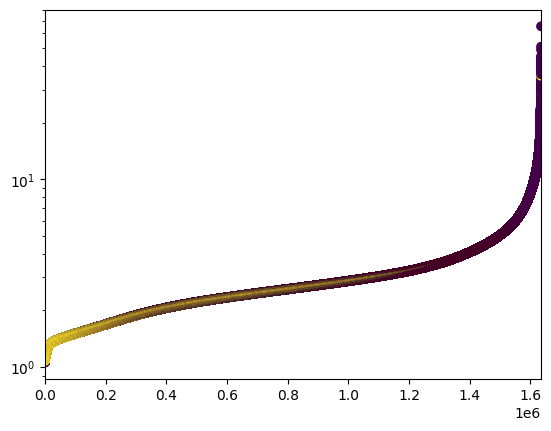

In [26]:
# Plot values from test colored if inter or intra cluster, x axis is index
plt.scatter(range(len(res)), res[:, 0], c=res[:, 1])
# Set vertical scale to be logarithmic
plt.yscale('log')
# Zoom out horizontal scale
plt.xlim(-100, len(res) + 100)
plt.show()